# Augmentation and Fine-Tuning

Imagine a situation in which we do not have 25,000 pictures to train. And not even 3000. And there are only 300. In such situations, data augmentation is useful. We will also use fine-tuning to improve the quality of the classification.

## Import of Required Libs

In [1]:
import os
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Augmentation

In [2]:
path_to_files = '../datasets/transfer_learning/train'

images = [os.path.join(dp, f) for dp, dn, filenames 
          in os.walk(path_to_files) for f in filenames
          if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

num_classes = 2

In [3]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [23]:
MAX_CAT_SIZE = 150
AUG_NUM = 9

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

data = []
cats_counter = 0
dogs_counter = 0
for img_path in images:
    category = img_path.split('/')[-1].split('\\')[-1].split('.')[0]
    if category == 'dog' and dogs_counter < MAX_CAT_SIZE:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':0})
        
        for _ in range(AUG_NUM):
            aug_x = data_augmentation(x)
            data.append({'x':np.array(aug_x[0]), 'y':0})
            
        dogs_counter += 1
    elif category == 'cat' and cats_counter < MAX_CAT_SIZE:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':1})
        
        for _ in range(AUG_NUM):
            aug_x = data_augmentation(x)
            data.append({'x':np.array(aug_x[0]), 'y':1})
        
        cats_counter += 1
    elif dogs_counter == MAX_CAT_SIZE and cats_counter == MAX_CAT_SIZE:
        break

In [24]:
len(data)

3000

In [25]:
np.random.shuffle(data)
train_split = 0.8
idx_test = int((train_split) * len(data))

data_train = data[:idx_test]
data_test = data[idx_test:]

In [26]:
x_train, y_train = np.array([t["x"] for t in data_train]), [t["y"] for t in data_train]
x_test, y_test = np.array([t["x"] for t in data_test]), [t["y"] for t in data_test]

In [27]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## VGG16 + Classification Layer + Fine-Tuning

In [28]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model = Model(inp, out)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [39]:
# Fine-tune at this layer
fine_tune_at = 2

for l, layer in enumerate(model.layers[:-1]):
    layer.trainable = False

# ensure these layers is trainable/not frozen
model.layers[-1].trainable = True
model.layers[fine_tune_at].trainable = True

In [42]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [43]:
%%time
history = model.fit(x_train, y_train, batch_size=50, epochs=10)

Epoch 1/10
48/48 [==============================] - 748s 16s/step - loss: 0.6466 - accuracy: 0.6722
Epoch 2/10
48/48 [==============================] - 754s 16s/step - loss: 0.2811 - accuracy: 0.9112
Epoch 3/10
48/48 [==============================] - 746s 16s/step - loss: 0.2029 - accuracy: 0.9338
Epoch 4/10
48/48 [==============================] - 740s 15s/step - loss: 0.1643 - accuracy: 0.9553
Epoch 5/10
48/48 [==============================] - 737s 15s/step - loss: 0.1336 - accuracy: 0.9554
Epoch 6/10
48/48 [==============================] - 741s 15s/step - loss: 0.1231 - accuracy: 0.9580
Epoch 7/10
48/48 [==============================] - 737s 15s/step - loss: 0.1037 - accuracy: 0.9669
Epoch 8/10
48/48 [==============================] - 738s 15s/step - loss: 0.0918 - accuracy: 0.9756
Epoch 9/10
48/48 [==============================] - 737s 15s/step - loss: 0.0850 - accuracy: 0.9760
Epoch 10/10
48/48 [==============================] - 739s 15s/step - loss: 0.0752 - accuracy: 0.9828

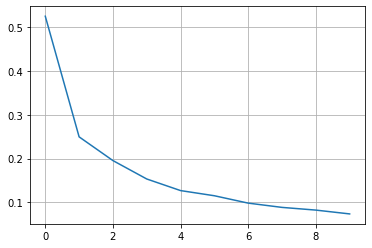

In [44]:
plt.plot(history.history['loss'])
plt.grid(True)
plt.show()

In [45]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.07731444388628006
Test accuracy: 0.9750000238418579


**Final accuracy on test data: 97.5%**

In [46]:
# 2.jpg - dog picture
category = 0 
img, x = get_image('../datasets/transfer_learning/test/2.jpg')
probabilities = model.predict([x])
category == probabilities.argmax()

True

In [47]:
# 7.jpg - cat picture
category = 1
img, x = get_image('../datasets/transfer_learning/test/7.jpg')
probabilities = model.predict([x])
category == probabilities.argmax()

True

## Saving the model

In [48]:
model.save('../keras_models/vgg_model_with_aug_and_tun')

INFO:tensorflow:Assets written to: ../keras_models/vgg_model_with_aug_and_tun\assets
